C:\Users\leej10\AppData\Local\Temp\ipykernel_33632\321330365.py:117: DeprecationWarning: __or__ is deprecated in favor of numpy.hstack.
  D = D_in | D_out


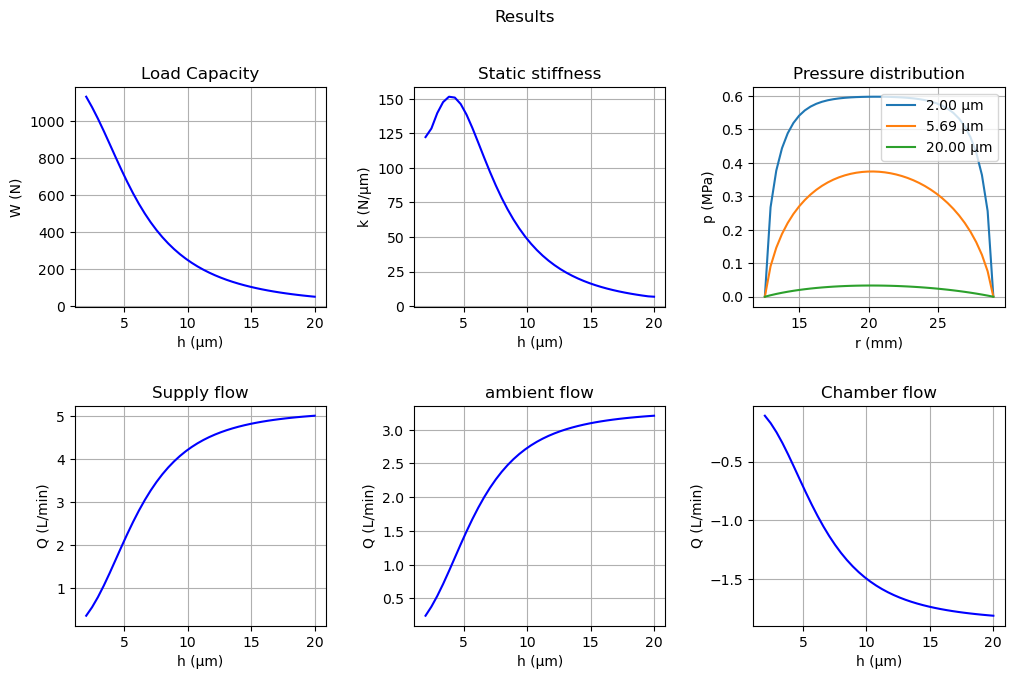

In [15]:
import numpy as np
from skfem import *
from skfem.helpers import grad, dot
import matplotlib.pyplot as plt

# ----------------
# Inputs / params
# ----------------
geom = "annular thrust"       # "annular thrust" or "circular thrust"
r0, r1 = 12.5e-3, 29e-3       # inner & outer radii; for "circular thrust" you can set r0 = 0.0
#r0, r1 = 0, 36.83/2 *1e-3  # inner & outer radii; for "circular thrust" you can set r0 = 0.0
n_elements = 40

# Gas & porous parameters
mu    = 1.85e-5               # Pa·s (air)
rho   = 1.2932                   # kg/m^3  (use your value; kept explicit)
pa    = 1.013e5                   # ambient [Pa]
ps    = 7.01325e5                   # supply  [Pa]
pc=pa                         # chamber pressure [Pa] (for annular thrust, set pc = pa)
#pc=3e5                         
Kp    = 1.44e-15#8.14e-16 #1.52e-15              # permeability [m^2]
delta = 0.0045                # porous thickness [m]

# film thickness sweep
h_values = np.linspace(2e-6, 20e-6, 40)   # you can keep your list if preferred

# ----------------
# Mesh & basis
# ----------------
mesh = MeshLine(np.linspace(r0, r1, n_elements + 1)).with_boundaries({
    "inner": lambda x: np.isclose(x[0], r0),
    "outer": lambda x: np.isclose(x[0], r1),
})
basis = Basis(mesh, ElementLineP1())
rin = r0; rout = r1
r_coords = basis.doflocs[0]

# ----------------
# Helpers (forms)
# ----------------

# Weak form for η := (ps^2 - p^2),  1/r d/dr ( r dη/dr ) = (12 Kp)/(h^3 δ) η
# -> ∫ r η' v' dr  - ∫ r K2 η v dr = 0
def assemble_matrix(basis, K2):
    @BilinearForm
    def a(u, v, w):
        r = w.x[0]
        return r * (grad(u)[0] * grad(v)[0]) + K2 * r * u * v
    return a.assemble(basis)

# Load: W = ∫ (p - pa) dA; axisymmetric dA = 2π r dr
@LinearForm
def load_form(v, w):
    # w.p provided as field = pressure
    r = w.x[0]
    return 2.0 * np.pi * r * (w.p - w.pa) * v


# Q_out [L/min] = ∮ 6e4 * weight * [ -(h^3 / (12 μ)) * (∇p · n) ] ds
# - pass `p` as your nodal pressure array (same basis as η), not a DiscreteField
# - pass `h` as a scalar or nodal array (same basis); if varying along the edge, it’s handled
# - `weight` handles geometry: thrust=2πr, journal z-ends=R, φ-sides=1/R
def make_qfilm_p(weight, *, mu: float = 1.0, p_ref: float = 1e5):
    """
    Build a LinearForm for total volumetric flow [L/min] across a boundary:
        q_n = -(h^3/(12 μ)) * (∇p · n)
        Q = ∮ 6e4 * weight * q_n ds
    weight: float or callable(w) giving the geometric factor for ds:
        - Thrust inner/outer:  lambda w: 2*np.pi*w.x[0]
        - Journal axial ends:  R
        - Journal φ-sides:     1.0   (no extra factor; grad already has 1/R)
    mu: viscosity [Pa·s]
    """
    if callable(weight):
        W = weight
    else:
        const = float(weight)
        W = lambda w: const
    K = 60000.0 / (24.0 * mu * p_ref) #p ref is ambient usually    
    @LinearForm
    def qfilm(v, w):
        h    = w['h']
        pval = w['p']                       # ABSOLUTE pressure
        #qn = - rho*(h**3) / (12.0 * mu) * dot(grad(w['p']), w.n)
        #qn = - rho*(h**3) / (12.0 *pa* mu) * dot(grad(w['eta']), w.n)
        dpdn = dot(grad(w['p']), w.n)

        qn = - K*(h**3) * (2*pval* dpdn)
        
        return  W(w) * qn * v          # → L/min
    return qfilm

#q_total = asm(qfilm, fb, eta=eta, h=h, p=p, mu=mu, weight=weight)

# ----------------
# FEM sweep + post
# ----------------

def solve_one(h):
    # problem constants at this h
    K2 = 12.0 * Kp / (h**3 * delta)

    # assemble
    A = assemble_matrix(basis, K2)

    # Dirichlet lift for η
    #   supply (p = ps)   -> η = ps^2 - ps^2 = 0
    #   ambient (p = pa)  -> η = ps^2 - pa^2
    x0 = basis.zeros()
    D_in  = basis.get_dofs("inner")
    D_out = basis.get_dofs("outer")

    if geom.lower() == "annular thrust":
        # inner = supply, outer = ambient
        x0[D_in]  = (ps**2 - pc**2)
        x0[D_out] = (ps**2 - pa**2)
        D = D_in | D_out
    elif geom.lower() == "circular thrust":
        if np.isclose(r0, 0.0):
            # symmetry (no-flux) at r=0  -> natural BC; ambient at outer
            x0[D_out] = (ps**2 - pa**2)
            D = D_out
        else:
            # hole at center acts like supply
            #x0[D_in]  = 0.0
            x0[D_in]  = (ps**2 - pc**2)
            x0[D_out] = (ps**2 - pa**2)
            D = D_in | D_out
    else:
        raise ValueError("geom must be 'annular thrust' or 'circular thrust'.")

    # solve for η
    eta = solve(*condense(A, x=x0, D=D))

    # pressure from η
    p = np.sqrt(np.maximum(ps**2 - eta, 0.0))

    # --- Load
    pfield = basis.interpolate(p)
    W = asm(load_form, basis, p=pfield, pa=pa).sum()    # [N]

    # --- Boundary flows (film)
    # Convert η-flux to volumetric flow using your original scaling:
    # Q [L/min] = 6e4 * (h^3 * rho) / (12 μ pa) * ∫_∂Ω (2π r) * (∇η · n) ds
    conv = 6e4 * (h**3 * rho) / (12.0 * mu * pa) /2

    fb_in  = basis.boundary('inner')
    fb_out = basis.boundary('outer')

    w_thrust = lambda w:  2* np.pi * w.x[0]

    q_thrust = make_qfilm_p( w_thrust, mu=mu, p_ref=pa)
    q_out_Lmin = asm(q_thrust, fb_out, p=p, h=h).sum()
    q_in_Lmin  = -asm(q_thrust, fb_in,  p=p, h=h).sum() if fb_in.nelems > 0 else 0.0
    # outward-positive convention (out of the film domain)
    #r outward-positive convention in for chamber/annulus out for ambient


    # Interpretations (match your original):
    qa = q_out_Lmin             # ambient flow (to outside)
    qc = q_in_Lmin              # chamber/supply side (to the plenum)
    qs = qa - qc                # supply flow through the porous pad into film

    return p, W, qa, qc, qs

# run sweep
pressure_profiles = []     # (h, r, p(r))
loads = []
qa_list, qc_list, qs_list = [], [], []

for h in h_values:
    p, W, qa, qc, qs = solve_one(h)
    pressure_profiles.append((h, r_coords.copy(), p.copy()))
    loads.append(W)
    qa_list.append(qa)
    qc_list.append(qc)
    qs_list.append(qs)

loads = np.array(loads)
qa_arr = np.array(qa_list)
qc_arr = np.array(qc_list)
qs_arr = np.array(qs_list)

# stiffness: dW/dh (sign convention like your get_stiffness)
k_stat = -np.gradient(loads, h_values)

# ----------------
# Plots (6 panels)
# ----------------
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(2, 3, wspace=0.35, hspace=0.45)

# 1) Load
ax = fig.add_subplot(gs[0,0])
ax.plot(h_values*1e6, loads, 'b')
ax.set_xlabel('h (µm)'); ax.set_ylabel('W (N)'); ax.set_title('Load Capacity'); ax.grid(True)

# 2) Stiffness
ax = fig.add_subplot(gs[0,1])
ax.plot(h_values*1e6, k_stat/1e6, 'b')
ax.set_xlabel('h (µm)'); ax.set_ylabel('k (N/µm)'); ax.set_title('Static stiffness'); ax.grid(True)

# 3) Pressure distributions (pick a few h) 
# Using Gauge Pressure
ax = fig.add_subplot(gs[0,2])
for (h, r_plot, p_plot) in [pressure_profiles[0],
                            pressure_profiles[len(pressure_profiles)//5],
                            pressure_profiles[-1]]:
    ax.plot(r_plot*1e3, (p_plot-pa)*1e-6, label=f'{h*1e6:.2f} µm')
ax.set_xlabel('r (mm)'); ax.set_ylabel('p (MPa)'); ax.set_title('Pressure distribution')
ax.legend(); ax.grid(True)

# 4) Supply flow (qs)
ax = fig.add_subplot(gs[1,0])
ax.plot(h_values*1e6, qs_arr, 'b')
ax.set_xlabel('h (µm)'); ax.set_ylabel('Q (L/min)'); ax.set_title('Supply flow'); ax.grid(True)

# 5) Ambient flow (qa)
ax = fig.add_subplot(gs[1,1])
ax.plot(h_values*1e6, qa_arr, 'b')
ax.set_xlabel('h (µm)'); ax.set_ylabel('Q (L/min)'); ax.set_title('ambient flow'); ax.grid(True)

# 6) Chamber/Plenum flow (qc)
ax = fig.add_subplot(gs[1,2])
ax.plot(h_values*1e6, qc_arr, 'b')
ax.set_xlabel('h (µm)'); ax.set_ylabel('Q (L/min)'); ax.set_title('Chamber flow'); ax.grid(True)

fig.suptitle('Results', y=0.99)
plt.show()

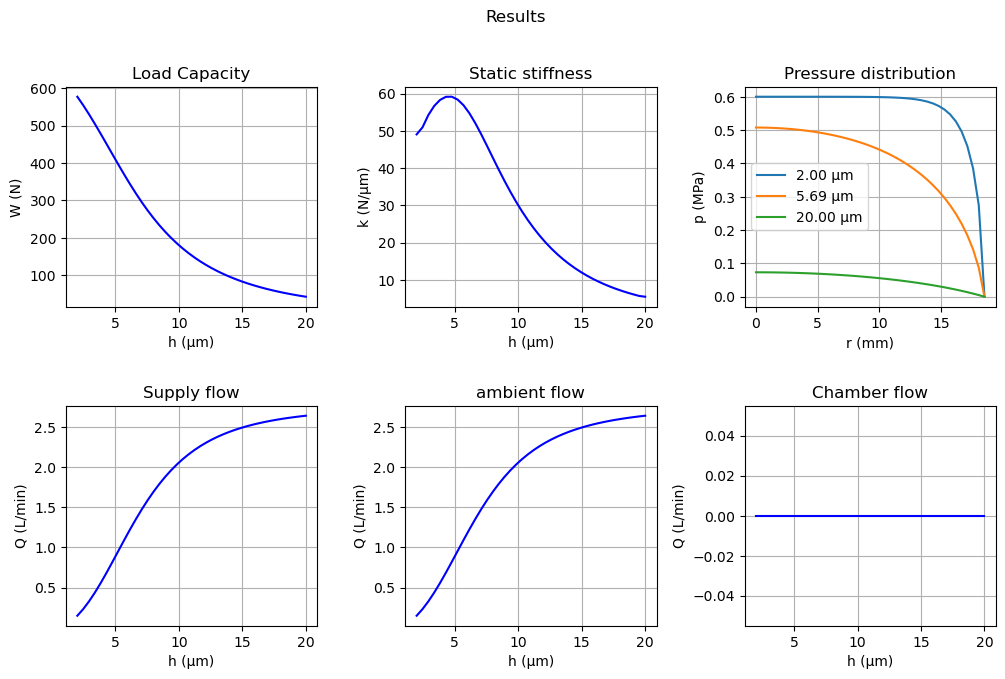

In [16]:
#using fem utils for plots

import numpy as np
from skfem import *
from skfem.helpers import grad, dot
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(".."))
sys.path.append(r"C:\Users\leej10\SK_FEM_Python")
sys.path.append(r"C:\Users\leej10\SK_FEM_Python\CompletedCases")
sys.path.append(r"C:\Users\leej10\SK_FEM_Python\openairbearing")
from fem_utils import (
    load_circular_axial,   # axial & radial load forms (slant–r parametrization)
    qfilm_circular_rim,     # p^2 boundary flow weight for r=const edges
)
# ----------------
# Inputs / params
# ----------------
geom = "circular thrust"       # "annular thrust" or "circular thrust"
r0, r1 = 0, 18.5e-3       # inner & outer radii; for "circular thrust" you can set r0 = 0.0
#r0, r1 = 0, 36.83/2 *1e-3  # inner & outer radii; for "circular thrust" you can set r0 = 0.0
n_elements = 40

# Gas & porous parameters
mu    = 1.85e-5               # Pa·s (air)
rho   = 1.2932                   # kg/m^3  (use your value; kept explicit)
pa    = 1.013e5                   # ambient [Pa]
ps    = 7.01325e5                   # supply  [Pa]
pc=pa                         # chamber pressure [Pa] (for annular thrust, set pc = pa)
#pc=3e5                         
Kp    = 1.52e-15#8.14e-16 #1.52e-15              # permeability [m^2]
delta = 0.0045                # porous thickness [m]

# film thickness sweep
h_values = np.linspace(2e-6, 20e-6, 40)   # you can keep your list if preferred

# ----------------
# Mesh & basis
# ----------------
mesh = MeshLine(np.linspace(r0, r1, n_elements + 1)).with_boundaries({
    "inner": lambda x: np.isclose(x[0], r0),
    "outer": lambda x: np.isclose(x[0], r1),
})
basis = Basis(mesh, ElementLineP1())
rin = r0; rout = r1
r_coords = basis.doflocs[0]

# ----------------
# Helpers (forms)
# ----------------

# Weak form for η := (ps^2 - p^2),  1/r d/dr ( r dη/dr ) = (12 Kp)/(h^3 δ) η
# -> ∫ r η' v' dr  - ∫ r K2 η v dr = 0
def assemble_matrix(basis, K2):
    @BilinearForm
    def a(u, v, w):
        r = w.x[0]
        return r * (grad(u)[0] * grad(v)[0]) + K2 * r * u * v
    return a.assemble(basis)



# ----------------
# FEM sweep + post
# ----------------

def solve_one(h):
    # problem constants at this h
    K2 = 12.0 * Kp / (h**3 * delta)

    # assemble
    A = assemble_matrix(basis, K2)

    # Dirichlet lift for η
    #   supply (p = ps)   -> η = ps^2 - ps^2 = 0
    #   ambient (p = pa)  -> η = ps^2 - pa^2
    x0 = basis.zeros()
    D_in  = basis.get_dofs("inner")
    D_out = basis.get_dofs("outer")

    if geom.lower() == "annular thrust":
        # inner = supply, outer = ambient
        x0[D_in]  = (ps**2 - pc**2)
        x0[D_out] = (ps**2 - pa**2)
        D = D_in | D_out
    elif geom.lower() == "circular thrust":
        if np.isclose(r0, 0.0):
            # symmetry (no-flux) at r=0  -> natural BC; ambient at outer
            x0[D_out] = (ps**2 - pa**2)
            D = D_out
        else:
            # hole at center acts like supply
            #x0[D_in]  = 0.0
            x0[D_in]  = (ps**2 - pc**2)
            x0[D_out] = (ps**2 - pa**2)
            D = D_in | D_out
    else:
        raise ValueError("geom must be 'annular thrust' or 'circular thrust'.")

    # solve for η
    eta = solve(*condense(A, x=x0, D=D))

    # pressure from η
    p = np.sqrt(np.maximum(ps**2 - eta, 0.0))

    # --- Load
    pfield = basis.interpolate(p)
    W = asm(load_circular_axial(), basis, p=pfield, pa=pa).sum()  # [N]


    # --- Boundary flows (film)
    # Convert η-flux to volumetric flow using your original scaling:
    # Q [L/min] = 6e4 * (h^3 * rho) / (12 μ pa) * ∫_∂Ω (2π r) * (∇η · n) ds
    conv = 6e4 * (h**3 * rho) / (12.0 * mu * pa) /2

    fb_in  = basis.boundary('inner')
    fb_out = basis.boundary('outer')

    

    q_thrust = qfilm_circular_rim(mu=mu, p_ref=pa)   # p^2-form, returns L/min
    q_out_Lmin = asm(q_thrust, fb_out, p=p, h=h).sum()
    q_in_Lmin  = -asm(q_thrust, fb_in,  p=p, h=h).sum() if fb_in.nelems > 0 else 0.0
    # outward-positive convention (out of the film domain)
    #r outward-positive convention in for chamber/annulus out for ambient


    # Interpretations (match your original):
    qa = q_out_Lmin             # ambient flow (to outside)
    qc = q_in_Lmin              # chamber/supply side (to the plenum)
    qs = qa - qc                # supply flow through the porous pad into film

    return p, W, qa, qc, qs

# run sweep
pressure_profiles = []     # (h, r, p(r))
loads = []
qa_list, qc_list, qs_list = [], [], []

for h in h_values:
    p, W, qa, qc, qs = solve_one(h)
    pressure_profiles.append((h, r_coords.copy(), p.copy()))
    loads.append(W)
    qa_list.append(qa)
    qc_list.append(qc)
    qs_list.append(qs)

loads = np.array(loads)
qa_arr = np.array(qa_list)
qc_arr = np.array(qc_list)
qs_arr = np.array(qs_list)

# stiffness: dW/dh (sign convention like your get_stiffness)
k_stat = -np.gradient(loads, h_values)

# ----------------
# Plots (6 panels)
# ----------------
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(2, 3, wspace=0.35, hspace=0.45)

# 1) Load
ax = fig.add_subplot(gs[0,0])
ax.plot(h_values*1e6, loads, 'b')
ax.set_xlabel('h (µm)'); ax.set_ylabel('W (N)'); ax.set_title('Load Capacity'); ax.grid(True)

# 2) Stiffness
ax = fig.add_subplot(gs[0,1])
ax.plot(h_values*1e6, k_stat/1e6, 'b')
ax.set_xlabel('h (µm)'); ax.set_ylabel('k (N/µm)'); ax.set_title('Static stiffness'); ax.grid(True)

# 3) Pressure distributions (pick a few h) 
# Using Gauge Pressure
ax = fig.add_subplot(gs[0,2])
for (h, r_plot, p_plot) in [pressure_profiles[0],
                            pressure_profiles[len(pressure_profiles)//5],
                            pressure_profiles[-1]]:
    ax.plot(r_plot*1e3, (p_plot-pa)*1e-6, label=f'{h*1e6:.2f} µm')
ax.set_xlabel('r (mm)'); ax.set_ylabel('p (MPa)'); ax.set_title('Pressure distribution')
ax.legend(); ax.grid(True)

# 4) Supply flow (qs)
ax = fig.add_subplot(gs[1,0])
ax.plot(h_values*1e6, qs_arr, 'b')
ax.set_xlabel('h (µm)'); ax.set_ylabel('Q (L/min)'); ax.set_title('Supply flow'); ax.grid(True)

# 5) Ambient flow (qa)
ax = fig.add_subplot(gs[1,1])
ax.plot(h_values*1e6, qa_arr, 'b')
ax.set_xlabel('h (µm)'); ax.set_ylabel('Q (L/min)'); ax.set_title('ambient flow'); ax.grid(True)

# 6) Chamber/Plenum flow (qc)
ax = fig.add_subplot(gs[1,2])
ax.plot(h_values*1e6, qc_arr, 'b')
ax.set_xlabel('h (µm)'); ax.set_ylabel('Q (L/min)'); ax.set_title('Chamber flow'); ax.grid(True)

fig.suptitle('Results', y=0.99)
plt.show()